In [1]:
from util.batteryreader import get_battery_details
from util.GurobiOptimizer import GurobiOptimizer
from tqdm import tqdm
import sys
import numpy as np
import pandas as pd

from util.config import PROJECT_NAME, WINDOW_LENGTH

index, available, SOC_a_v, SOC_d_v, t_a_v, t_d_v = get_battery_details(window_length = 30)

GurobiOptimizer = GurobiOptimizer()

sys.stdout = open(f'./output/output_log_{PROJECT_NAME}.txt', 'w')

for idx in tqdm(range(len(available)), desc='Processing series', unit='series'):  
    # print(f"\n\nSeries num: {idx}", index[idx])
    
    available_current = np.array(available[idx])
    SOC_d_v_current = np.array(SOC_d_v[idx])
    SOC_a_v_current = np.array(SOC_a_v[idx])
    t_a_v_current = np.array(t_a_v[idx])
    t_d_v_current = np.array(t_d_v[idx])
    
    print(f"Number of available batteries: {len(available_current[idx])}")
    print(f"Time arrival: {t_a_v_current}")
    print(f"Time departure: {t_d_v_current}")
    print(f"State of Charge (SoC) at the beginning of availability: {SOC_d_v_current}")
    print(f"State of Charge (SoC) at the end of availability: {SOC_a_v_current}")

    assert all(x >= 0 for x in t_a_v_current), "Invalid arrival time"
    assert all(0 <= x <= WINDOW_LENGTH for x in t_d_v_current), "Invalid departure time"
    assert not np.any(pd.isna(available_current)), "Availability has NaN"

    initial_demand, final_grid_demand, charging_demand, pv = GurobiOptimizer.optimize(
        index[idx], available[idx], t_a_v[idx], t_d_v[idx], SOC_a_v[idx], SOC_d_v[idx]
    )
    
sys.stdout.close()
sys.stdout = sys.__stdout__



Processing series:   9%|▉         | 29/308 [00:34<05:35,  1.20s/series]


KeyboardInterrupt: 

18.0305
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.91, 21.91, 26.68, 52.08, 41.85, 44.62, 54.43, 90.65, 46.49, 19.97, 14.35, 6.73]
24


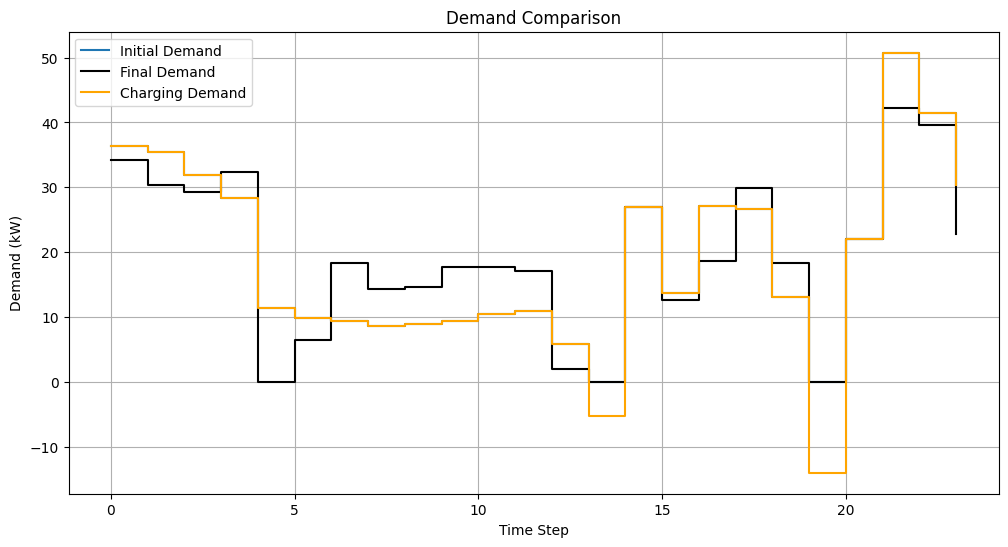

In [ ]:
import matplotlib.pyplot as plt
from pyparsing import col

print(sum(charging_demand))
print([round(float(i),2) for i in pv])
print(len(pv))
plt.figure(figsize=(12, 6))
plt.step(range(len(initial_demand)), initial_demand , label='Initial Demand', where='post')
plt.step(range(len(final_grid_demand)), final_grid_demand, label='Final Demand', color='black', where='post')
plt.step(range(len(charging_demand)), [final_grid_demand[i] - charging_demand[i] for i in range(len(charging_demand))], label='Charging Demand', color='orange', where='post')
plt.xlabel('Time Step')
plt.ylabel('Demand (kW)')
plt.title('Demand Comparison')
plt.legend()
plt.grid(True)
plt.show()